In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../../')

from skyburst.plot import *
from skyburst import utils

# Fig 12: Ablate 90th JCT.

In [2]:
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/ablate_jct_percentile.log').expanduser()
helios_jct_df = utils.load_logs_as_dataframe(log_path)

In [6]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(right=2.75)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'avg_waiting': 'Wait Time (hr.)',
}

legend_dict = {
    'constant': 'Constant-Wait',
    'linear_capacity_filter_cpu': 'Star-Wait',
    'linear_cost_filter_cpu': 'Compute-Wait',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:blue',
    'Compute-Wait': 'tab:red',
    'Star-Wait': 'tab:orange',
    'Constant-Wait + No-SJ': 'tab:green',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    if not isinstance(axs, list):
        axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
#     diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', 'o','^', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label == 'zero':
            continue
        label = legend_dict[label[0]]
        for ax_idx, ax in enumerate(axs):
            # if ax_idx < 2 and label=='No-Wait':
            #     continue
            color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, markersize=7, ax = ax, color=color, label = label, legend=None, linewidth=1.5)
            plt.plot(grp[x_axis],  grp['90_wait_x'], color=color, marker=marker,  markersize=7, linestyle=(0, (1, 1)), alpha=1.0, linewidth=3)
            #plt.plot(grp[x_axis],  grp['99_wait_x'], color=color, linestyle='dotted', alpha=1.0, linewidth=3)
            ##plt.fill_between(grp[x_axis], grp[ mod_y_axis[ax_idx]], grp['90_wait_x'], color=color, alpha=0.4)
            ##plt.fill_between(grp[x_axis], grp[ mod_y_axis[ax_idx]], grp['99_wait_x'], color=color, alpha=0.2)


# plt.fill_between(dates, p90_values, p99_values, color="salmon", alpha=0.4, label="99th Percentile")
    from matplotlib.lines import Line2D
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    # print(labels)
    fig.legend(lines + [Line2D([0], [0], color='black', lw=1.5), Line2D([0], [0], color='black', linestyle=(0, (1, 1)), lw=3)], labels + ['50%', '90%'], bbox_to_anchor=(0, 1.07, 1.1, 0.2),  ncol=2,loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios_90.pdf', bbox_inches='tight')
    #plt.savefig('figures/evaluation/helios_99.pdf', bbox_inches='tight')
    plt.show()  

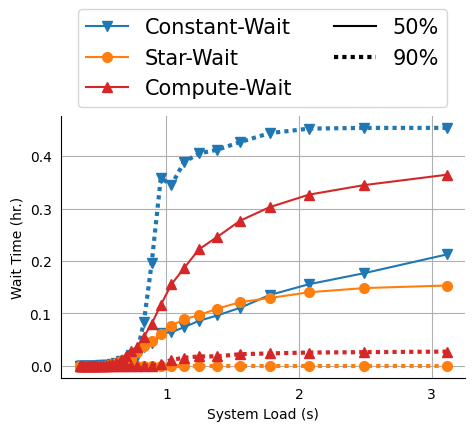

In [7]:
simulator_plotting_fn(helios_jct_df, x_axis='cluster_size',  \
                      y_axis=['avg_waiting'], \
                      baseline_filter={'waiting_policy': 'constant', 'loop': 0},
                      groupby_values=['waiting_policy', ],
                      normalize_x_axis=True)

# Fig 12: Ablate 99th JCT

In [11]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(right=2.75)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'avg_waiting': 'Wait Time (hr.)',
}

legend_dict = {
    'constant': 'Constant-Wait',
    'linear_capacity_filter_cpu': 'Star-Wait',
    'linear_cost_filter_cpu': 'Compute-Wait',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:blue',
    'Compute-Wait': 'tab:red',
    'Star-Wait': 'tab:orange',
    'Constant-Wait + No-SJ': 'tab:green',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    if not isinstance(axs, list):
        axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', 'o','^', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label == 'zero':
            continue
        label = legend_dict[label[0]]
        for ax_idx, ax in enumerate(axs):
            color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, markersize=7, ax = ax, color=color, label = label, legend=None, linewidth=1.5)
            plt.plot(grp[x_axis],  grp['99_wait_x'], color=color, marker=marker,  markersize=7, linestyle=(0, (1, 1)), alpha=1.0, linewidth=3)
            #plt.plot(grp[x_axis],  grp['99_wait_x'], color=color, linestyle='dotted', alpha=1.0, linewidth=3)
            ##plt.fill_between(grp[x_axis], grp[ mod_y_axis[ax_idx]], grp['90_wait_x'], color=color, alpha=0.4)
            ##plt.fill_between(grp[x_axis], grp[ mod_y_axis[ax_idx]], grp['99_wait_x'], color=color, alpha=0.2)


# plt.fill_between(dates, p90_values, p99_values, color="salmon", alpha=0.4, label="99th Percentile")
    from matplotlib.lines import Line2D
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    # print(labels)
    fig.legend(lines + [Line2D([0], [0], color='black', lw=1.5), Line2D([0], [0], color='black', linestyle=(0, (1, 1)), lw=3)], labels + ['50%', '99%'], bbox_to_anchor=(0, 1.07, 1.1, 0.2),  ncol=2,loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios_99.pdf', bbox_inches='tight')
    plt.show()  

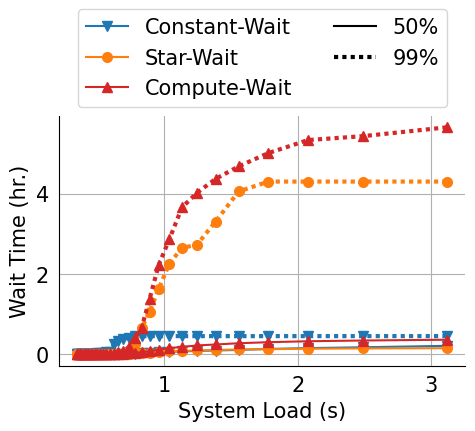

In [12]:
simulator_plotting_fn(helios_jct_df, x_axis='cluster_size',  \
                      y_axis=['avg_waiting'], \
                      baseline_filter={'waiting_policy': 'constant', 'loop': 0},
                      groupby_values=['waiting_policy', ],
                      normalize_x_axis=True)